In [1]:
import sys

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L

from sklearn import datasets
from dal_toolbox.models.ensemble import Ensemble, EnsembleTrainer, EnsembleOptimizer

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


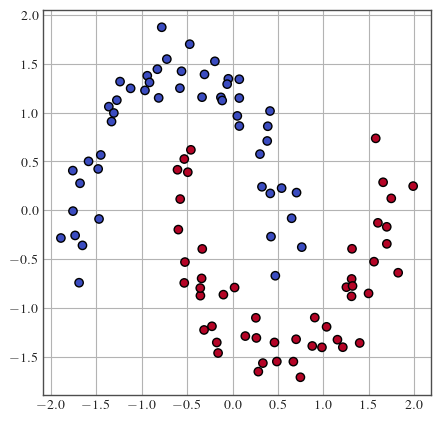

In [2]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
class Net(nn.Module):
    def __init__(self,
                 num_classes: int,
                 dropout_rate: int = .2,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        return out

# from dal_toolbox.models.ensemble.base import EnsembleModule
# from dal_toolbox.models.utils.callbacks import MetricsHistory
# class Ensemble(EnsembleModule):
#     def __init__(self, num_members=10):
#         super().__init__([Net(2) for _ in range(num_members)])
#     
#     def configure_optimizers(self):
#         optimizers = [torch.optim.SGD(m.parameters(), lr=1e-1, momentum=0.9) for m in self.members]
#         return optimizers

In [4]:
@torch.no_grad()
def plot_contour(model, domain=5, ax=None):
    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model.forward_sample(zz)
    probas = logits.softmax(-1)
    probas = probas.mean(1)
    zz = probas[:, 1].view(xx.shape)

    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

Epoch [1] Model [0]  [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.6940 (0.6940) acc1: 0.5100 (0.5100) time: 0.1641 data: 0.0011 max mem: 17
Epoch [1] Model [0]  Total time: 0:00:00
Epoch [1] Model [1]  [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.6774 (0.6774) acc1: 0.6600 (0.6600) time: 0.0020 data: 0.0006 max mem: 18
Epoch [1] Model [1]  Total time: 0:00:00
Epoch [1] Model [2]  [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.6543 (0.6543) acc1: 0.7000 (0.7000) time: 0.0020 data: 0.0006 max mem: 18
Epoch [1] Model [2]  Total time: 0:00:00
Epoch [1] Model [3]  [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.7114 (0.7114) acc1: 0.4300 (0.4300) time: 0.0023 data: 0.0008 max mem: 19
Epoch [1] Model [3]  Total time: 0:00:00
Epoch [1] Model [4]  [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.7319 (0.7319) acc1: 0.3900 (0.3900) time: 0.0024 data: 0.0008 max mem: 19
Epoch [1] Model [4]  Total time: 0:00:00
Epoch [1] Model [5]  [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.6877 (0.6877) acc1: 0.5700 (0.5700) time: 0.0023 data: 0.0008 max mem: 

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


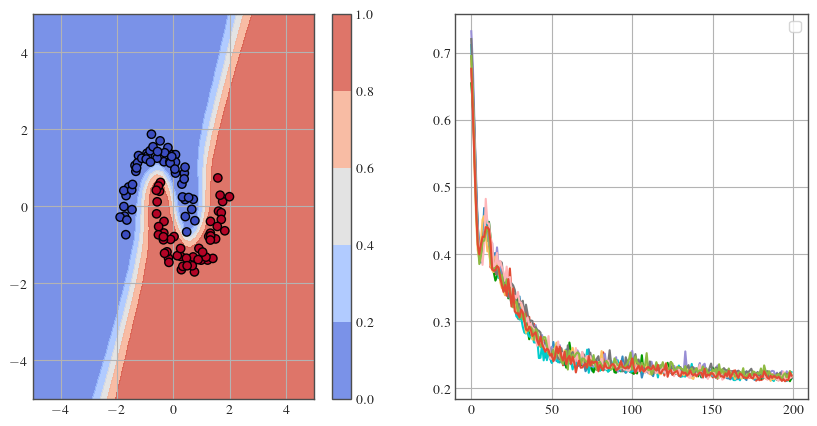

In [5]:
num_members = 10
num_epochs = 100
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

members = [Net(2) for _ in range(num_members)]
optimizer = EnsembleOptimizer([torch.optim.SGD(m.parameters(), lr=1e-1, momentum=0.9) for m in members])
model = Ensemble(members)
trainer = EnsembleTrainer(
    model,
    criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
    optimizer=optimizer,
    num_epochs=200,
)
history = trainer.fit(train_loader)
train_history = history['train_history']

model.eval()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_contour(model)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.subplot(122)
plt.legend()
for i in range(num_members):
    plt.plot([d[f'train_loss_member{i}'] for d in train_history], label=f'Member {i}')
plt.show()

In [84]:
%timeit model.forward_sample(torch.ones(300, 2))

887 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [85]:
%timeit [member(torch.ones(300, 2)) for member in model]

1.42 ms ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
